# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [9]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load in the train and test datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [11]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [12]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [13]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


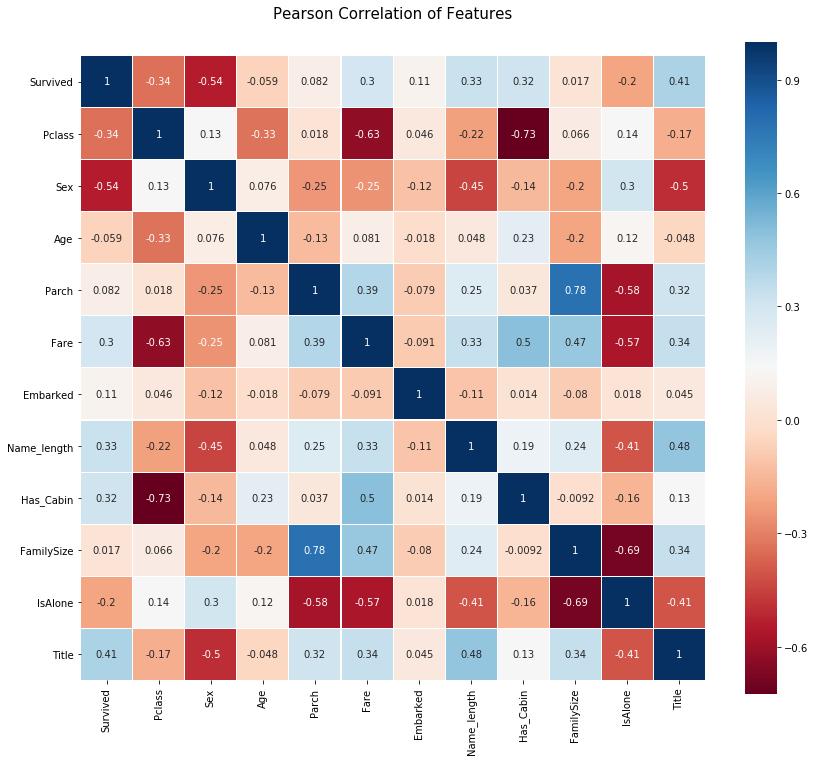

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

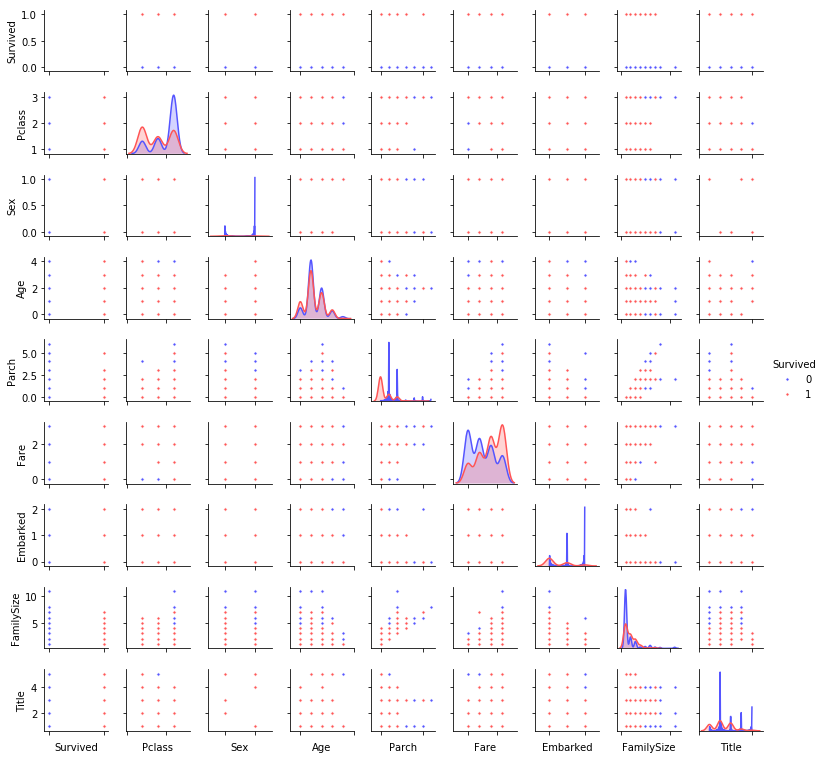

In [15]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                        u'Embarked', u'FamilySize', u'Title']],
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [16]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(train.drop("Survived", axis=1), train.Survived, test_size=.3, random_state=17)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [17]:
tree_params = {'max_depth': range(1, 6),
               'max_features': range(1, 10),
              }
gbc = GradientBoostingClassifier(random_state=17)
gbc_grid = GridSearchCV(gbc, gbc_params, cv=skf)

rfc = RandomForestClassifier(random_state=17)
rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf)

svc = SVC(random_state=17)
svc_grid = GridSearchCV(svc, svc_params, cv=skf)

lr = LogisticRegression(random_state=17)
lr_grid = GridSearchCV(lr, lr_params, cv=skf)

models = [("gbc", gbc_grid), ("rfc", rfc_grid), ("svc", svc_grid), ("lr", lr_grid)]
for name, model in models:    
    model.fit(x_train, y_train)
    print(f"{name} best params:\n{model.best_params_}")

gbc best params:
{'learning_rate': 0.1}
rfc best params:
{'min_samples_leaf': 2, 'n_estimators': 30}
svc best params:
{'C': 0.9000000000000001, 'kernel': 'rbf'}
lr best params:
{'C': 0.5}


In [18]:
from sklearn.metrics import accuracy_score

In [19]:
for name, model in models:
    y_predict = model.predict(x_test)
    print(f"{name} accuracy: {accuracy_score(y_test, y_predict)}")

gbc accuracy: 0.7611940298507462
rfc accuracy: 0.7761194029850746
svc accuracy: 0.7723880597014925
lr accuracy: 0.7947761194029851


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [29]:
xgb_params = {'n_estimators': range(10, 100, 10),
              'eta': np.arange(0.1, 1., .2),
              'min_child_weight': range(1, 10, 2),
              'subsample': np.arange(0.1, 1., 0.2)}

In [21]:
meta_mtrx = np.empty((y_test.shape[0], len(models)))
for n, (name, model) in enumerate(models):
    y_predict = model.predict(x_test)
    meta_mtrx[:,n] = y_predict
meta_mtrx[:10]

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 1.]])

In [22]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


In [25]:
models

[('gbc',
  GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
               error_score='raise-deprecating',
               estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                    init=None, learning_rate=0.1,
                                                    loss='deviance', max_depth=3,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                          

In [30]:
xgb = XGBClassifier(random_state=17)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=skf)
print(f"Blending XGBoost start fitting ...")
xgb_grid.fit(meta_mtrx, y_test)
print(f"Blending XGBoost finished fitting ...")

data_test = test

meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
for n, (name, model) in enumerate(models):
    print(f"Model {name} started ...")
    meta_mtrx_test[:,n] = model.predict(data_test)
    print(f"Model {name} finished!")
print(f"Blending XGBoost start predicting ...")
meta_predict = xgb_grid.predict(meta_mtrx_test)
print(f"Blending XGBoost best params:\n{xgb_grid.best_params_}")


Blending XGBoost start fitting ...
Blending XGBoost finished fitting ...
Model gbc started ...
Model gbc finished!
Model rfc started ...
Model rfc finished!
Model svc started ...
Model svc finished!
Model lr started ...
Model lr finished!
Blending XGBoost start predicting ...
Blending XGBoost best params:
{'eta': 0.1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.9000000000000001}


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [33]:
def train_test_for_stacking(data, targets, folds_count, test_fold_num):
    part_size = data.shape[0] // folds_count
    if test_fold_num == folds_count - 1:
        return (
            data[:part_size*test_fold_num],
            data[part_size*test_fold_num:],
            targets[:part_size*test_fold_num],
            targets[part_size*test_fold_num:],
        )
    return (
        np.append(data[:part_size*test_fold_num], data[part_size*(test_fold_num + 1):]).reshape(-1, data.shape[1]),
        data[part_size*test_fold_num:part_size*(test_fold_num + 1)],
        np.append(targets[:part_size*test_fold_num], targets[part_size*(test_fold_num + 1):]).reshape(-1, 1),
        targets[part_size*test_fold_num:part_size*(test_fold_num + 1)],
    )
    

def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, folds_num=3):
    if folds_num <= 1:
        raise ValueError("folds_num must be greater than 1")
    meta_mtrx_parts = []
    for fold_ind in range(folds_num):
        train, valid, train_true, valid_true = train_test_for_stacking(data_train, targets_train, folds_num, fold_ind)
        
        meta_mtrx_part = np.empty((valid.shape[0], len(models)))

        for n, model in enumerate(models):
            print(f"Model {n} started fitting...")
            model_fitted = model.fit(train, train_true)
            print(f"Model {n} started predicting...")
            meta_mtrx_part[:, n] = model_fitted.predict(valid)

        meta_mtrx_parts.append(meta_mtrx_part)

    meta_mtrx = np.vstack(meta_mtrx_parts)
    
    print("Meta alg started fitting...")
    meta_model = meta_alg.fit(meta_mtrx, targets_train)

    meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
    
    for n, model in enumerate(models):
        meta_mtrx_test[:,n] = model.predict(data_test)
    print("Meta alg started predicting...")
    meta_predict = meta_alg.predict(meta_mtrx_test)

    if targets_test is not None:
        print(f"Stacking AUC: {roc_auc_score(targets_test, meta_predict)}")
    return meta_predict

In [34]:
predicted = stacking([m for _, m in models], xgb_grid, train.drop("Survived", axis=1), train.Survived, test)

Model 0 started fitting...
Model 0 started predicting...
Model 1 started fitting...
Model 1 started predicting...
Model 2 started fitting...
Model 2 started predicting...
Model 3 started fitting...
Model 3 started predicting...
Model 0 started fitting...
Model 0 started predicting...
Model 1 started fitting...
Model 1 started predicting...
Model 2 started fitting...
Model 2 started predicting...
Model 3 started fitting...
Model 3 started predicting...
Model 0 started fitting...
Model 0 started predicting...
Model 1 started fitting...
Model 1 started predicting...
Model 2 started fitting...
Model 2 started predicting...
Model 3 started fitting...
Model 3 started predicting...
Meta alg started fitting...
Meta alg started predicting...


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [35]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [37]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


In [38]:
write_to_submission_file(predicted, list(range(test.shape[0])))

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ: